In [2]:
import numpy as np
import pandas as pd
import re
import random
import transformers
import matplotlib.pyplot as plt
import json
import pickle
import torch

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

/usr/local/Caskroom/miniconda/base/envs/roline/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/kaybrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kaybrian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2024-10-23 07:20:01.798864: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelBinarizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Import BERT-base pretrained model
bert_model = BertModel.from_pretrained('bert-base-uncased')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
df = pd.read_csv("./crop_diseases.csv")
df.head(20)

,Questions,Answers,Patterns,Tags
0,What is crop rotation?,Crop rotation is the practice of growing diffe...,Can you explain the concept of crop rotation?,Crop Rotation
1,What is the primary benefit of crop rotation?,The primary benefit of crop rotation is the im...,Why is crop rotation beneficial?,Soil Health
2,What is a cover crop?,A cover crop is a plant grown primarily to pro...,What is the purpose of a cover crop?,Cover Crops
3,What are common cover crops?,"Common cover crops include clover, rye, and ve...",Can you name some examples of cover crops?,Crop Examples
4,What is monoculture?,Monoculture is the agricultural practice of gr...,What does monoculture mean?,Monoculture
5,What are the disadvantages of monoculture?,Disadvantages of monoculture include increased...,What are the downsides of monoculture?,Crop Diversity
6,What is integrated pest management (IPM)?,Integrated pest management (IPM) is a pest con...,Can you describe integrated pest management?,Pest Management
7,What are some common pests that affect corn?,Common pests that affect corn include the corn...,What pests commonly infest corn?,Corn Pests
8,What is late blight in potatoes?,Late blight is a serious disease of potatoes c...,What causes late blight in potatoes?,Potato Diseases
9,How can late blight in potatoes be managed?,Late blight can be managed by using resistant ...,What are the management practices for late bli...,Disease Management


In [9]:
# Creating intents dictionary
dict_ = {"intents": []}

for ind in df.index:
    questions = df['Questions'][ind].lower().replace('?', '.').split('.')
    patterns = [q.strip() for q in questions if q.strip()]
    patterns.append(df['Patterns'][ind].lower().strip())
    responses = df['Answers'][ind]
    tag = df['Tags'][ind]

    dict1 = {'tags': [tag], 'patterns': patterns, 'responses': [responses]}
    dict_['intents'].append(dict1)

print(dict_["intents"][:2])

with open("crops.json", "w") as f:
    json.dump(dict_, f)

[{'tags': ['Crop Rotation'], 'patterns': ['what is crop rotation', 'can you explain the concept of crop rotation?'], 'responses': ['Crop rotation is the practice of growing different types of crops in the same area in sequential seasons to improve soil health and reduce pests.']}, {'tags': ['Soil Health'], 'patterns': ['what is the primary benefit of crop rotation', 'why is crop rotation beneficial?'], 'responses': ['The primary benefit of crop rotation is the improvement of soil fertility and the reduction of soilborne diseases and pests.']}]


In [10]:
words=[]
classes=[]
documents=[]
ignore_letters=['?','!','.',',']
lemmatizer = WordNetLemmatizer()

# for intent in dict_['intents']:
#   for pattern in intent['patterns']:
#     if isinstance(pattern, str):
#       pattern = pattern.strip()
#       word_list = tokenizer(pattern)
#       words.extend(word_list)
#       documents.append((pattern, intent['tags']))
#       if intent['tags'] not in classes:
#         classes.append(intent['tags'])

# lemmatizer=WordNetLemmatizer()

# words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
# words = sorted(set(words))
# classes = sorted(set(classes))

# pickle.dump(words, open('words.pkl', 'wb'))
# pickle.dump(classes, open('classes.pkl', 'wb'))

def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

for intent in dict_['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            word_list = tokenizer.tokenize(pattern)
            words.extend(word_list)
            documents.append((pattern, intent['tags'][0]))
            if intent['tags'][0] not in classes:
                classes.append(intent['tags'][0])

words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

In [11]:
# # Prepare training data
# training = []
# output_empty = [0] * len(classes)
# label_binarizer = LabelBinarizer()
# label_binarizer.fit(classes)

# for document in documents:
#   pattern = document[0]
#   tag = document[1]
#   # tokenize & convert to BERT embeddings
#   inputs = tokenizer(pattern, return_tensors='pt', padding=True, truncation=True)
#   with torch.no_grad():
#     outputs = model(**inputs)
#   embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
#   output_row = label_binarizer.transform([tag])[0]
#   # print(output_row)
#   training.append((embeddings.flatten(), output_row))

# # print(training)
# # Shuffle and prepare the training data
# random.shuffle(training)
# training = np.array(training, dtype=object)

# train_x = np.array([item[0] for item in training])
# train_y = np.array([item[1] for item in training])


# Prepare training data
training = []
output_empty = [0] * len(classes)
label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

for document in documents:
    pattern = document[0]
    tag = document[1]
    embedding = get_bert_embedding(pattern)
    output_row = label_binarizer.transform([tag])[0]
    training.append((embedding.flatten(), output_row))

random.shuffle(training)
training = np.array(training, dtype=object)

train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

In [14]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

model=Sequential()
model.add(Dense(128,input_shape=(len(train_x[1]),),activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(train_y[0]),activation='softmax'))


# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Use the SGD optimizer with the learning rate schedule
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
# sgd=SGD(learning_rate=0.0001,decay=1e-6,momentum=0.9,nesterov=True)


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','Precision','Recall'])
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=METRICS)
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,158 (426.40 KB)

 Trainable params: 109,158 (426.40 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [15]:
hist = model.fit(np.array(train_x),np.array(train_y),epochs=50,batch_size=12,verbose=1)
model.save('chatbotmodel.h5', hist)
print('Training Done')

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0134 - loss: 3.7090   
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0543 - loss: 3.5213    
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1473 - loss: 3.3704
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1500 - loss: 3.2768
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2314 - loss: 3.1085
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1670 - loss: 2.9141
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2797 - loss: 2.6602
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy:

Training Done


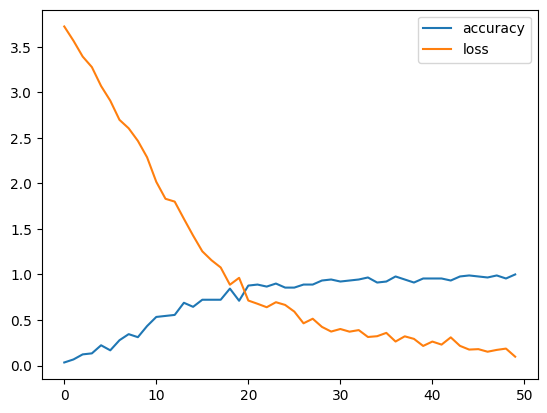

In [16]:
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['loss'],label='loss')
# plt.show()
plt.legend()

In [17]:
# Load the model for prediction
model = load_model('chatbotmodel.h5')

def predict_class(sentence):
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]['intent']
    for i in intents_json['intents']:
        if tag in i['tags']:
            return random.choice(i['responses'])
    return "Sorry, I don't understand."

print("GO! BOT IS RUNNING")

while True:
    message = input("")
    if message.lower() in ['quit', 'exit']:
        print("Goodbye")
        break
    ints = predict_class(message)
    if ints:
        res = get_response(ints, dict_)
        print(f"Bot: {res}")
    else:
        print("Bot: Sorry, I don't understand.")

GO! BOT IS RUNNING
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Bot: Sorry, I don't understand.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Bot: Sorry, I don't understand.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Bot: Sorry, I don't understand.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Bot: Crop rotation is the practice of growing different types of crops in the same area in sequential seasons to improve soil health and reduce pests.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Bot: The primary benefit of crop rotation is the improvement of soil fertility and the reduction of soilborne diseases and pests.
Goodbye
